# Importing Libraries

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, GRU, Input, Embedding
from keras.utils import plot_model
from keras.models import Model

# Reading dataset

In [2]:
df = pd.read_csv('train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
df.drop(['keyword', 'location', 'id'], axis= 1, inplace = True)
df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
print((df.target ==1).sum())
print((df.target ==0).sum())

3271
4342


## Data Preprocessing

In [15]:
# preprocessing
import re
import string

def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S")
    return url.sub(r"", text)


def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

In [12]:
pattern = re.compile(r"https?://(\S+|www)\.\S+")

for t in df.text:
    matches = pattern.findall(t)
    for match in matches:
        print(t)
        print(match)
        print(pattern.sub(r"", t))
    if len(matches) > 0:
        break

@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C
t
@bbcmtd Wholesale Markets ablaze 


In [16]:
df['text'] = df['text'].map(remove_URL)
df['text'] = df['text'].map(remove_punctuation)

In [17]:
# remove stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = set(stopwords.words('english'))

def remove_stopwords(text):
    filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
    
    return ' '.join(filtered_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
df['text'] = df['text'].map(remove_stopwords)

In [20]:
df.head()

,text,target
0,deeds reason earthquake may allah forgive us,1
1,forest fire near la ronge sask canada,1
2,residents asked shelter place notified officer...,1
3,13000 people receive wildfires evacuation orde...,1
4,got sent photo ruby alaska smoke wildfires pou...,1


# Conting all words

In [22]:
from collections import Counter

def count_word(text_col):
    count = Counter()
    
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

counter = count_word(df['text'])

In [25]:
# printing 5 most common words
counter.most_common(5)

[('like', 345), ('im', 299), ('amp', 298), ('fire', 250), ('get', 229)]

In [26]:
# getting total no of unique words for embeddings
num_unique_words = len(counter)

In [27]:
# splitting the data
# train to val ratio: 80:20

train_size = int(df.shape[0] * 0.8)

train_df = df[: train_size]
val_df = df[train_size:]

# split text and labels
train_sentences = train_df.text.to_numpy()
train_labels = train_df.target.to_numpy()

val_sentences = val_df.text.to_numpy()
val_labels = val_df.target.to_numpy()

In [28]:
train_sentences.shape, val_sentences.shape

((6090,), (1523,))

In [29]:
# tokenizing the sentences
tokenizer = Tokenizer(num_words= num_unique_words, oov_token= '<OOV>')
tokenizer.fit_on_texts(train_sentences)

In [31]:
# getting index of words
word_index = tokenizer.word_index
# word_index

In [164]:
train_sentences

array(['deeds reason earthquake may allah forgive us',
       'forest fire near la ronge sask canada',
       'residents asked shelter place notified officers evacuation shelter place orders expected',
       ..., 'feel like sinking unhappiness take quiz',
       'sinking music video tv career brooke hogan thanking dad free publicityalthough doubt help',
       'supernovalester feel bad literally feel feeling heart sinking bc didnt get anyone ugh jfc'],
      dtype=object)

In [32]:
# converting words into numbers

train_sequences = tokenizer.texts_to_sequences(train_sentences)
val_sequences = tokenizer.texts_to_sequences(val_sentences)

In [34]:
print(train_sentences[1])
print(train_sequences[1])

forest fire near la ronge sask canada
[72, 4, 130, 577, 5672, 5673, 1284]


In [127]:
# maxlen = 20

# padding the sentences to same length
train_padded = pad_sequences(train_sequences, padding = 'post', truncating='post', maxlen = 25)
val_padded = pad_sequences(val_sequences, padding = 'post', truncating = 'post', maxlen = 25)

In [128]:
print(train_sentences[1])
print(train_sequences[1])
print(train_padded[1])

forest fire near la ronge sask canada
[72, 4, 130, 577, 5672, 5673, 1284]
[  72    4  130  577 5672 5673 1284    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]


In [129]:
# flip key value pair
reverse_word_index = dict([(index, word) for (word, index) in word_index.items()])
# reverse_word_index

In [130]:
# to decode the sentence back to words
def decode(sequence):
    # lst = []
    # for index in sequence:
    #     lst.append(reverse_word_index[index])
    # return ' '.join(lst)
    
    
    
    return ' '.join(reverse_word_index.get(idx, '?') for idx in sequence)

In [131]:
decode(train_sequences[10])

'three people died heat wave far'

In [132]:
num_unique_words

17972

In [142]:
# creating the model


inputs = Input(shape = (25,), name = 'Input_layer')
embedding = Embedding(num_unique_words, 300, name = 'Embedding')(inputs)
lstm = LSTM(256, return_sequences= False, name = 'LSTM')(embedding)
dense = Dense(1, activation = 'sigmoid', name = 'Dense')(lstm)

In [143]:
model = Model(inputs = inputs, outputs = dense)

In [144]:
# optimizer and loss function
loss = keras.losses.BinaryCrossentropy(from_logits = False)
optim = keras.optimizers.Adam()
metrics = ['accuracy']

model.compile(loss = loss, optimizer = optim, metrics = metrics)

In [145]:
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 25)]              0         
                                                                 
 Embedding (Embedding)       (None, 25, 300)           5391600   
                                                                 
 LSTM (LSTM)                 (None, 256)               570368    
                                                                 
 Dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 5,962,225
Trainable params: 5,962,225
Non-trainable params: 0
_________________________________________________________________


In [146]:
plot_model(model)
plt.show()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [148]:
train_padded.shape, val_padded.shape

((6090, 25), (1523, 25))

In [149]:
history = model.fit(train_padded, train_labels,
          epochs = 25,
          validation_data= (val_padded, val_labels))

Epoch 1/25
191/191 [==============================] - 36s 171ms/step - loss: 0.5809 - accuracy: 0.6938 - val_loss: 0.5101 - val_accuracy: 0.7800
Epoch 2/25
191/191 [==============================] - 31s 164ms/step - loss: 0.3152 - accuracy: 0.8808 - val_loss: 0.5241 - val_accuracy: 0.7807
Epoch 3/25
191/191 [==============================] - 31s 164ms/step - loss: 0.1725 - accuracy: 0.9460 - val_loss: 0.6544 - val_accuracy: 0.7557
Epoch 4/25
191/191 [==============================] - 31s 163ms/step - loss: 0.1186 - accuracy: 0.9655 - val_loss: 0.6570 - val_accuracy: 0.7426
Epoch 5/25
191/191 [==============================] - 31s 163ms/step - loss: 0.0954 - accuracy: 0.9709 - val_loss: 0.8361 - val_accuracy: 0.7308
Epoch 6/25
191/191 [==============================] - 32s 165ms/step - loss: 0.0690 - accuracy: 0.9750 - val_loss: 0.9951 - val_accuracy: 0.7301
Epoch 7/25
191/191 [==============================] - 31s 165ms/step - loss: 0.0567 - accuracy: 0.9783 - val_loss: 1.3649 - val_ac

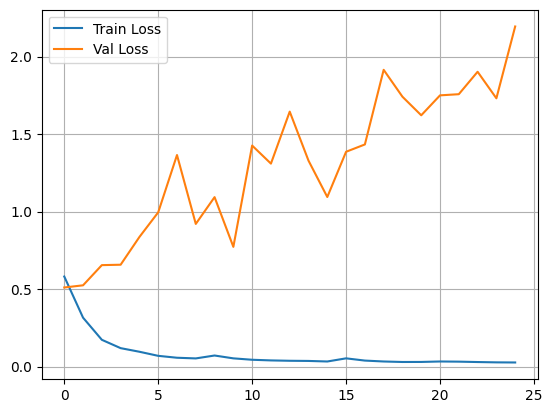

In [150]:
plt.plot(history.history['loss'], label = 'Train Loss');
plt.plot(history.history['val_loss'], label = 'Val Loss');
plt.grid();
plt.legend()

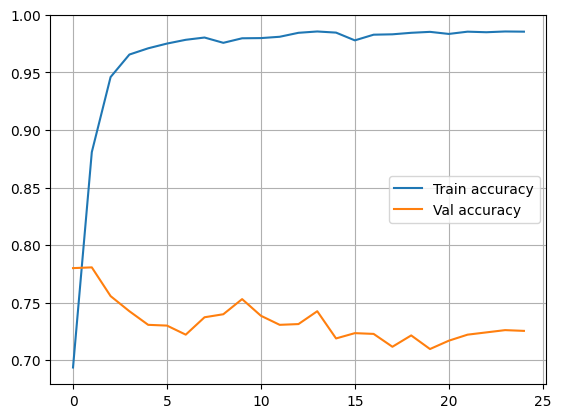

In [151]:
plt.plot(history.history['accuracy'], label = 'Train accuracy');
plt.plot(history.history['val_accuracy'], label = 'Val accuracy');
plt.grid();
plt.legend()

In [152]:
model.save('sentimen_analysis.h5')

In [153]:
# saving tokenizer
import pickle
tokenizer_file = 'tokenizer.pkl'

with open(tokenizer_file, 'wb') as f:
    pickle.dump(tokenizer, f)

In [157]:
predictions = model.predict(train_padded)

191/191 [==============================] - 6s 26ms/step


In [161]:
preds = [1 if p >= 0.5 else 0 for p in predictions]
# preds

In [163]:
print(train_labels[:10])
print(preds[:10])

[1 1 1 1 1 1 1 1 1 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [166]:
x = 'people died'

In [1]:
# encoder_inputs = Input(shape=(None, input_vocab_size))
# encoder = LSTM(num_neurons, return_state=True)
# encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# encoder_states = (state_h, state_c)

# decoder_inputs = Input(shape=(None, output_vocab_size))
# decoder_lstm = LSTM(num_neurons,return_sequences=True, return_state=True)
# decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
# decoder_dense = Dense(output_vocab_size, activation='softmax')
# decoder_outputs = decoder_dense(decoder_outputs)

# model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)

# model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
# model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size=batch_size, epochs=epochs)